In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
import plotly.express as px
import re
from collections import Counter

In [2]:
from utils_plotting import analyze_capitalization_patterns, plot_fully_capitalized_words, emoji_regex, contains_emoji, extract_emojis

In [3]:
# df1 = pd.read_csv("data/hatebase_trimmed.csv")
# df2 = pd.read_csv("data/superset_trimmed.csv")

In [ ]:
# # Step 1: Rename columns to be consistent
# df1_renamed = df1.rename(columns={"tweet": "text", "class": "labels"})
# df2_renamed = df2.rename(columns={"text": "text", "labels": "labels"})

# # Step 2: Select the same columns from both
# df1_final = df1_renamed[["text", "labels", "word_count"]]
# df2_final = df2_renamed[["text", "labels", "word_count"]]

# # Step 3: Concatenate the two DataFrames
# merged_df = pd.concat([df1_final, df2_final], ignore_index=True)
# merged_df

In [5]:
merged_df = pd.read_csv("data/merged.csv")
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534383 entries, 0 to 534382
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   text        534383 non-null  object 
 1   labels      534383 non-null  float64
 2   word_count  534383 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 12.2+ MB


### 📊 Dataset Overview

- **Total dataset size:**  
  `360K + 230K = 590K`

- **Duplicates identified:**  
  `1,600 + 13,100 = 14.7K`

- **Text entries exceeding 60 words [outliers]:**  
  `6,900 + 28,000 = ~35K`

- **Missing (NaN) values:**  
  `~300` after cleaning `removing emojis`

---

### ✅ Final Cleaned Dataset Size

**590K - 14.7K - 35K ≈ 540K entries**

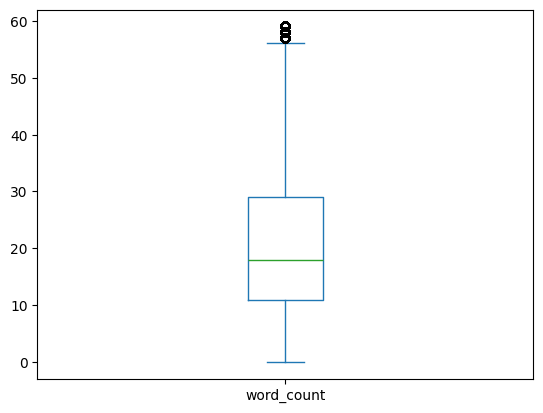

In [6]:
merged_df["word_count"].plot(kind="box");

> **Note:** The outliers displayed in the graph are statistically significant based on the Interquartile Range (IQR) method, but they are not practically concerning. Since the dataset will be capped at a maximum of 60 words, these values remain within acceptable limits for our analysis.

The platform has evolved from its original 140-character limit to 280 characters for standard users, and even further for X Premium subscribers. Nearly 40-50 words.

In [7]:
(merged_df["word_count"] > 57).sum()

3925

In [8]:
merged_df.duplicated().sum()

0

In [9]:
merged_df.isna().sum()

text          0
labels        0
word_count    0
dtype: int64

## Class Balance

In [10]:
merged_df["labels"].value_counts(normalize=True)

labels
0.0    0.671754
1.0    0.328246
Name: proportion, dtype: float64

## Hashtags

In [11]:
# 1. Filter tweets with hashtags
hashtag_df = merged_df[merged_df["text"].str.contains(r"#\w+", regex=True)].copy()

# 2. Extract & normalize hashtags
def extract_hashtags(text):
    return [tag.lower() for tag in re.findall(r"#(\w+)", text)]

hashtag_df["hashtags"] = hashtag_df["text"].apply(extract_hashtags)

# 3. Explode into rows
exploded = hashtag_df.explode("hashtags")
exploded = exploded[exploded["hashtags"].notna() & (exploded["hashtags"] != "")]

# 4. Count hashtag usage by label
hashtag_counts = exploded.groupby(["labels", "hashtags"]).size().reset_index(name="count")

# 5. Pivot for hate/safe comparison
pivot = hashtag_counts.pivot(index="hashtags", columns="labels", values="count").fillna(0)
pivot.columns = ["safe_count", "hate_count"]
pivot["total"] = pivot["safe_count"] + pivot["hate_count"]
pivot["hate_ratio"] = pivot["hate_count"] / pivot["total"]

# 6. Filter to hashtags used ≥ 5 times
pivot = pivot[pivot["total"] >= 5]

# 7. Top hashtags by hate ratio
top_hate_tags = pivot.sort_values("hate_ratio", ascending=False).head(20).reset_index()

# 🔥 Calculate total number of hashtags after filtering
total_valid_hashtags = pivot.shape[0]

# 🔥 Plot: Top hate-signaling hashtags
fig = px.bar(
    top_hate_tags,
    x="hate_ratio",
    y="hashtags",
    orientation="h",
    title=f"Top 20 Hashtags by Hate Ratio (Out of {total_valid_hashtags:,} Hashtags with ≥5 Uses)",
    labels={"hate_ratio": "Hate Ratio", "hashtags": "Hashtag"},
    text="hate_ratio"
)
fig.update_traces(texttemplate='%{text:.2f}', textposition="outside", marker_color="crimson")
fig.update_layout(template="plotly_white", yaxis=dict(categoryorder="total ascending"))
fig.show()


In [12]:
import plotly.express as px

# Reset pivot (if not already)
pivot = pivot.reset_index()

# Scatter plot
fig = px.scatter(
    pivot,
    x="total",
    y="hate_ratio",
    hover_name="hashtags",
    title=f"Hate Ratio vs Total Popularity (Out of {pivot.shape[0]:,} Hashtags with ≥5 Uses)",
    labels={"total": "Total Uses", "hate_ratio": "Hate Ratio"},
    size="total",  # Optional: make popular hashtags bigger
    color="hate_ratio",  # Color intensity based on hate ratio
    color_continuous_scale="RdBu",
)

fig.update_layout(template="plotly_white")
fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))
fig.show()


### 🏷️ Hashtag Analysis: Usage, Distribution & Hate Signal

To evaluate the role of hashtags in hate speech detection, I analyzed their usage patterns, distribution across labels, and normalized hate intensity.

#### 📌 Key Stats:
- **Total tweets**: ~530,000  
- **Tweets with hashtags**: ~171,950 (~32.4%)  
- **Unique hashtags (with ≥5 uses)**: 3,165  
- Hashtags are present in roughly **1 out of every 3 tweets**.

## Emojis

In [13]:
# 4. Filter and extract emojis from dataset
emoji_df = merged_df[merged_df["text"].apply(contains_emoji)].copy()
emoji_df["emojis"] = emoji_df["text"].apply(extract_emojis)

# 5. Explode to individual emoji rows
emoji_list = emoji_df["emojis"].explode().dropna().tolist()

# 6. Count emoji frequency
emoji_counter = Counter(emoji_list)
emoji_df_final = pd.DataFrame(emoji_counter.items(), columns=["emoji", "count"])
emoji_df_final = emoji_df_final.sort_values("count", ascending=False).head(20)

# 7. Plot with Plotly Express
fig = px.bar(
    emoji_df_final,
    x="emoji",
    y="count",
    text="count",
    title=f"Top 20 Emojis in Dataset (Out of {len(emoji_list):,} emojis in {emoji_df.shape[0]:,} tweets)",
    labels={"emoji": "Emoji", "count": "Frequency"},
)
fig.update_traces(marker_color="orange", textposition="outside")
fig.update_layout(template="plotly_white", xaxis=dict(tickmode='linear'))
fig.show()


In [14]:
# Filter tweets with emojis
emoji_labeled_df = merged_df[merged_df["text"].apply(lambda x: bool(emoji_regex.search(x)))].copy()
emoji_labeled_df["emojis"] = emoji_labeled_df["text"].apply(extract_emojis)

# Explode to 1 emoji per row
exploded_emojis = emoji_labeled_df.explode("emojis")
exploded_emojis = exploded_emojis[exploded_emojis["emojis"].notna()]

# Group by (label, emoji)
emoji_grouped = exploded_emojis.groupby(["labels", "emojis"]).size().reset_index(name="count")

# Pivot into hate/safe
pivot = emoji_grouped.pivot(index="emojis", columns="labels", values="count").fillna(0)
pivot.columns = ["safe_count", "hate_count"] if 0 in pivot.columns else ["hate_count", "safe_count"]
pivot["total"] = pivot["safe_count"] + pivot["hate_count"]
pivot["hate_ratio"] = pivot["hate_count"] / pivot["total"]

# Filter for emojis used at least 5 times
pivot = pivot[pivot["total"] >= 5].sort_values("hate_ratio", ascending=False).reset_index()

# (Continue from previous pivot)
pivot = pivot[pivot["total"] >= 5].reset_index()  # Already has hate_ratio, total, safe/hate counts

# Plot with Plotly Express
fig = px.scatter(
    pivot,
    x="total",
    y="hate_ratio",
    size="total",
    color="hate_ratio",
    color_continuous_scale="RdBu_r",
    hover_name="emojis",
    title=f"Hate Ratio vs Total Popularity (Out of {pivot.shape[0]:,} Emojis Used ≥5 Times)",
    labels={"total": "Total Uses", "hate_ratio": "Hate Ratio"},
)

fig.update_layout(template="plotly_white")
fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))
fig.show()


## Cleaning the merged dataset

### 🔤 Lowercasing Decision

Originally, I considered **preserving casing** — why? Because intuitively, there's a clear emotional difference between _"kill"_ and _"KILL"_, especially in the context of hate speech. I wanted the model to potentially weigh capitalized words more heavily.

However, after running some analysis on the dataset, it became evident that **fully capitalized words are relatively rare**, and most of them are **formatting artifacts** like `LINK`, `RT`, `URL`, or generic function words like `AND`, `TO`, `THE`. Only a handful (e.g., `F***`, `NO`, `YOUR`) carried any expressive weight — and even those were infrequent.

👉 **Conclusion**: The dataset doesn't offer enough consistent signal in casing to justify preserving it.  
So, I decided to **lowercase all text** for cleaner preprocessing and more stable training.

In [15]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=True)
print(tokenizer.tokenize("kill"))
print(tokenizer.tokenize("KILL"))
print(tokenizer.tokenize("Kill"))

['kill']
['KILL']
['Kill']


In [16]:
df_wo_emojis = pd.read_csv("data/merged_wo_emojis.csv")

In [17]:
analyze_capitalization_patterns(df_wo_emojis, column="clean_text")

In [18]:
plot_fully_capitalized_words(df_wo_emojis, column="clean_text")

### 🔡 Lowercasing Decision — Final Confirmation

Based on the full token-level analysis:

- **6.91%** of words started with a capital letter
- **3.00%** were fully capitalized
- Resulting in a **combined 9.91% (~1 million words)** being affected by lowercasing

This confirms that the impact of lowercasing is both **non-trivial** and **strategically beneficial**. By normalizing case, we reduce unnecessary vocabulary noise and improve model generalization without losing meaningful signal — since fully or title-cased words are not consistently tied to hate indicators in this dataset.

👉 **Conclusion**: Lowercasing ~10% of the vocabulary is not just safe — it's optimal.

## Symbols

In [ ]:
def punctuation_stats_overview(df, text_col="clean_text"):
    df = df.copy()
    df = df.dropna(subset=[text_col])

    # Define symbols and readable labels
    symbols = {
        "!": "Exclamation (!)",
        "?": "Question (?)",
        "#": "Hashtag (#)",
        ".": "Dot (.)",
        ",": "Comma (,)",
        "\"": 'Double Quote (")',
        "'": "Apostrophe (')",
        "*": "Asterisk (*)",
        "@": "At Symbol (@)",
        ":": "Colon (:)",
        ";": "Semicolon (;)",
        "...": "Ellipsis (...)"
    }

    # Count total occurrences of each symbol safely
    total_counts = {}
    for symbol, label in symbols.items():
        if symbol == "...":
            # Manual ellipsis handling (avoid escaping)
            count = df[text_col].str.count(r"\.\.\.").sum()
        else:
            escaped = re.escape(symbol)
            count = df[text_col].str.count(escaped).sum()
        total_counts[label] = int(count)

    # Prepare DataFrame
    symbol_df = pd.DataFrame(total_counts.items(), columns=["Symbol", "Total Count"])
    symbol_df = symbol_df.sort_values("Total Count", ascending=False)

    # Plot
    fig = px.bar(
        symbol_df,
        x="Symbol",
        y="Total Count",
        text="Total Count",
        title="🔣 Total Frequency of Punctuation Symbols in Dataset",
        labels={"Symbol": "Punctuation Symbol", "Total Count": "Count"},
    )
    fig.update_traces(textposition="outside", marker_color="darkslateblue")
    fig.update_layout(template="plotly_white", xaxis_tickangle=-45)
    fig.show()

In [20]:
df = pd.read_csv("data/merged_w_emojis.csv")
punctuation_stats_overview(df)

### ✨ Punctuation Preservation Decision

In earlier stages of preprocessing, I decided to **preserve expressive punctuation** such as `!`, `?`, `"`, and `...`, based on intuition. These symbols often convey **emotional tone**, **sarcasm**, or **intensity** — all of which can enhance the detection of hate speech.

To validate this decision, I analyzed the full dataset (~530,000 tweets, ~10M words) and measured the frequency of key emotional punctuation symbols:

| Symbol           | Count     |
|------------------|-----------|
| Exclamation `!`  | 62,174    |
| Question `?`     | 51,438    |
| Quote `"`        | 40,939    |
| Ellipsis `...`   | 27,105    |
| **Total**        | **181,656** |

This corresponds to:
- ~**1.8% of all words**
- ~**0.34 symbols per tweet** (on average)

🧠 **Interpretation**:
- These symbols appear frequently enough to contribute meaningful emotional context.
- While they don’t dominate the dataset, their presence is **non-trivial** — occurring in roughly **1 out of every 3 tweets**.
- The model can naturally learn subtle tone shifts (e.g., sarcasm, intensity) from their usage without explicit engineering.

👉 **Conclusion**:  
There is now **quantitative evidence** supporting the decision to **preserve expressive punctuation**. These symbols serve as lightweight emotional cues, especially valuable in nuanced hate speech detection scenarios.

## Cleaning

In [ ]:
def clean_and_track(text, lowercase=False, remove_emoji=False):
    mods = {
        "lowercased": False,
        "url_removed": False,
        "mention_removed": False,
        "link_token_removed": False,
        "emoji_removed": False,
        "whitespace_fixed": False,
    }

    def apply_and_track(pattern, repl, key, flags=0):
        nonlocal text
        new = re.sub(pattern, repl, text, flags=flags)
        if new != text:
            mods[key] = True
            text = new

    # Lowercase if enabled
    if lowercase:
        lowered = text.lower()
        if lowered != text:
            mods["lowercased"] = True
            text = lowered

    # Remove URLs and mentions
    apply_and_track(r"http\S+", "", "url_removed")
    apply_and_track(r"@\w+", "", "mention_removed")

    # Remove token "LINK" (case-insensitive)
    apply_and_track(r"\bLINK\b", "", "link_token_removed", flags=re.IGNORECASE)

    # Emoji removal (if enabled)
    if remove_emoji:
        apply_and_track(emoji_regex, "", "emoji_removed")

    # Fix whitespace
    apply_and_track(r"[\t\n\r]+", " ", "whitespace_fixed")
    apply_and_track(r"\s+", " ", "whitespace_fixed")
    text = text.strip()

    return text, mods

In [22]:
txt = "LINK @user check this: http://something.com 😎🚀"
cleaned, mods = clean_and_track(txt, lowercase=True, remove_emoji=True)

print("Cleaned Text:", cleaned)
print("Modifications:", mods)

Cleaned Text: check this:
Modifications: {'lowercased': True, 'url_removed': True, 'mention_removed': True, 'link_token_removed': True, 'emoji_removed': True, 'whitespace_fixed': True}


In [ ]:
# Apply the cleaning function
results = merged_df["text"].map(lambda x: clean_and_track(x, lowercase=True, remove_emoji=True))

# Extract cleaned text and mods
merged_df["clean_text"] = results.map(lambda x: x[0])
mod_counts = results.map(lambda x: x[1])

# Aggregate total modifications
mod_totals = Counter()
for mod in mod_counts:
    mod_totals.update({k: int(v) for k, v in mod.items()})

# Summarize as DataFrame (with optional percentage)
mod_summary = pd.DataFrame.from_dict(mod_totals, orient="index", columns=["count"])
mod_summary = mod_summary.sort_values("count", ascending=False)

In [1]:
mod_summary

NameError: name 'mod_summary' is not defined

In [25]:
merged_df.columns

Index(['text', 'labels', 'word_count', 'clean_text'], dtype='object')

In [26]:
# merged_df.to_csv("data/merged_w_emojis.csv", index=False)

In [27]:
list_idx_mismatch = []
for idx in range(merged_df.shape[0]):
    if merged_df["text"][idx] != merged_df["clean_text"][idx]:
        list_idx_mismatch.append(idx)

In [28]:
print(len(list_idx_mismatch))

294719


In [29]:
import random
for i in range(5):
    idx = random.choice(list_idx_mismatch)
    # idx = list_idx_mismatch[1]
    print("Before cleaning: ", merged_df["text"][idx])
    print("After  cleaning: ", merged_df["clean_text"][idx])
    print()

Before cleaning:  Is the baby still crying? Aw, don't cry, baby. Mommy will come to change your diaper.
After  cleaning:  is the baby still crying? aw, don't cry, baby. mommy will come to change your diaper.

Before cleaning:  #WHO #ExpertTeam visits #China for #COVID-19 control - Global Times They #control outside #Wuhan and #Hubei outside the #Epicenter of the #Epidemic . 🤔🧐 means they will again NOT check #GroundZero of #WuhanVirus #ChinaVirus  Useless trip LINK
After  cleaning:  #who #expertteam visits #china for #covid-19 control - global times they #control outside #wuhan and #hubei outside the #epicenter of the #epidemic . 🤔🧐 means they will again not check #groundzero of #wuhanvirus #chinavirus useless trip

Before cleaning:  #nbchitpiece #nbcisdogshit #heynbceatadick

Only a piece of shit liberal commy could do this
After  cleaning:  #nbchitpiece #nbcisdogshit #heynbceatadick only a piece of shit liberal commy could do this

Before cleaning:  May you reach the day early when y